<a href="https://colab.research.google.com/github/der41/XAI_Duke/blob/der41-patch-1/Notebooks/Explainable_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #02
### Telco Customer Churn - Kaggle
### Diego Rodriguez

# 0. Import Data, Dependencies, and Data Checks

In [ ]:
from typing_extensions import dataclass_transform
import os

# Remove Colab default sample_data
!rm -r ./sample_data ./XAI_Duke

# Clone GitHub files to colab workspace
repo_name = "XAI_Duke"
git_path = 'https://github.com/der41/XAI_Duke.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook
notebook_dir = 'Notebooks'
data_dir = 'data/Telco.csv'
notebook_path = os.path.join(repo_name,notebook_dir)
data_path = os.path.join(repo_name,data_dir)

rm: cannot remove './sample_data': No such file or directory
Cloning into 'XAI_Duke'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 25 (delta 5), reused 9 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 172.82 KiB | 2.83 MiB/s, done.
Resolving deltas: 100% (5/5), done.


## Importing the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.stats as ss
from scipy.special import expit  # sigmoid function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, roc_auc_score, log_loss, brier_score_loss
from pygam import LogisticGAM, s, l, te
from pygam.terms import TermList

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

df =pd.read_csv(data_path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Checking basic Data Info


In [ ]:
#data type
df.dtypes


,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


### Total Charge is a numeric feature, so should be converted to numbers

In [ ]:
# Converting Total Charges to a numerical data type.
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


### Some final transformations

In [ ]:
# Drop rows with missing TotalCharges if small; otherwise, impute
missing_before = df['TotalCharges'].isna().sum()
if missing_before > 0:
    df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)
print("Dropped rows with missing TotalCharges:", missing_before)

# Encode target
df['ChurnFlag'] = (df['Churn'].str.strip().str.lower() == 'yes').astype(int)

#encode SeniorCitizen as object
df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)

# Identify categorical vs numeric
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if c not in ['customerID']]  # exclude ID
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols = [c for c in num_cols if c not in ['ChurnFlag']]

df.info()

Dropped rows with missing TotalCharges: 11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16 

## 1. Exploratory Data Analysis (EDA) & Assumption Checks
I examine target balance, feature distributions, relationships, and model assumptions.
- **Class balance** for churn -> Close to 1/4 is a churn user.
- **Numeric** distributions and correlation heatmap
- **Categorical** target relationships (Cramér's V)
- **Collinearity** via VIF
- **Linearity & Homoscedasticity** (for linear regression)
- **Logit-linearity** (Box-Tidwell-like checks) for logistic regression

Churn rate: 26.6%


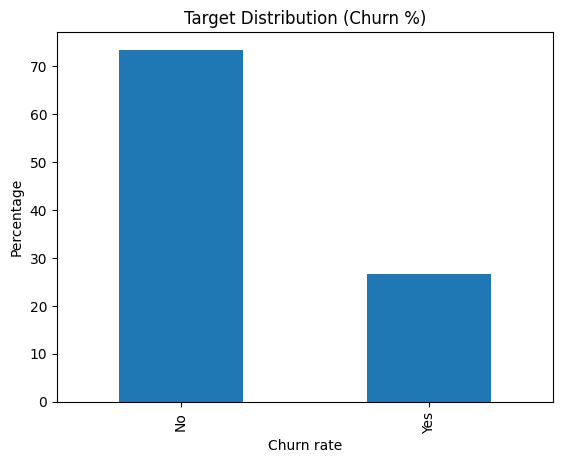

In [ ]:
# Target distribution
churn_rate = df['ChurnFlag'].mean()*100
print(f"Churn rate: {churn_rate:.1f}%")

fig = plt.figure()
df['ChurnFlag'].value_counts(normalize=True).mul(100).plot(kind='bar')
plt.title("Target Distribution (Churn %)")
plt.ylabel("Percentage")
plt.xlabel("Churn rate")
plt.xticks([0,1], ['No', 'Yes'])
plt.show()

*Figure 1: Barplot showing churn rate. Churn rate is close to 1/4 of the total dataset*

Imbalance of the 3:1 ratio. Is not that bad and doesnt suggest strong chages.

,count,mean,std,min,25%,50%,75%,max
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


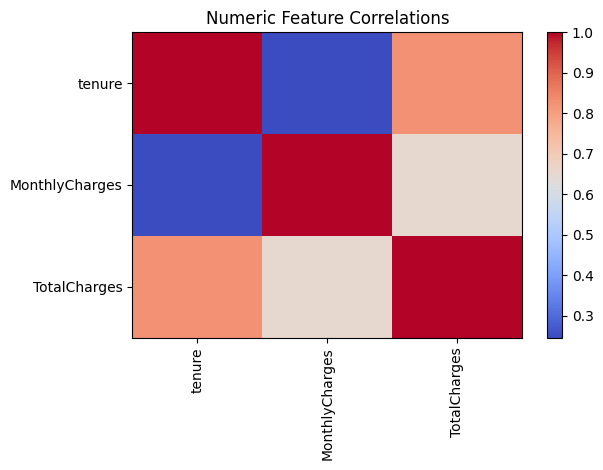

In [ ]:
# Numeric summary
display(df[num_cols].describe().T)

# Correlation among numeric predictors
corr = df[num_cols].corr()
plt.figure()
plt.imshow(corr, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title("Numeric Feature Correlations")
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.tight_layout()
plt.show()

*Figure 2: Correlation and summary statistics.*

Total Changes seems to show a high correlation with tenure and moderate with Monthly changes. Total changes seems to have a skew distribution based on the median and media numbers.

In [ ]:

# Cramér's V for categorical vs target a measure of how much

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0] #Pearson X2 statistic
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n # bias-correction
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1),(rcorr-1))) #Cramér’s V (bias-corrected)

cat_strength = []
for c in cat_cols:
    v = cramers_v(df[c], df['ChurnFlag'])
    cat_strength.append((c, v))
pd.DataFrame(cat_strength, columns=['CategoricalFeature','CramersV']).sort_values('CramersV', ascending=False).head(15)

,CategoricalFeature,CramersV
16,Churn,0.999636
13,Contract,0.409242
7,OnlineSecurity,0.346607
10,TechSupport,0.342115
6,InternetService,0.321490
15,PaymentMethod,0.302276
8,OnlineBackup,0.291435
9,DeviceProtection,0.280672
12,StreamingMovies,0.230101
11,StreamingTV,0.229541


*Figure 3: Summary table of the Cramér's V for multicategorical features compared to 'Churn Flag.*
- Churn is pretty much 1. Should be taken out as it shouldn't be part of the analysis.
- Contract to Device Protection have a moderate influence over churn
- Streaming to Partnet seems to have a low influence over churn
- Multiple Lines and Gender seems to have no influence over churn.

In [ ]:
#removing churn from categorical columns
cat_cols.remove('Churn')


#Trimming some names
internet_opts = ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
for c in internet_opts:
    df[c] = df[c].replace({"No internet service": "No"})
df["MultipleLines"] = df["MultipleLines"].replace({"No phone service": "No"})

In [ ]:
# One-hot encode categoricals for modeling.
X_num = df[num_cols].copy()
X_cat = pd.get_dummies(df[cat_cols], drop_first=True)

#All my variables
X = pd.concat([X_num, X_cat], axis=1)
y = df['ChurnFlag'].values

if (X.dtypes == "bool").any():
    X = X.astype(float)  # bool -> float (0.0/1.0)
else:
    # Safety if anything weird slipped in as object
    X = X.apply(pd.to_numeric, errors="raise").astype(float)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Scale the features
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("X shape:", X.shape, " y shape:", y.shape)
print("X_train shape:", X_train.shape, " y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, " y_test shape:", y_test.shape)
X_train.head()

X shape: (7032, 23)  y shape: (7032,)
X_train shape: (5625, 23)  y_train shape: (5625,)
X_test shape: (1407, 23)  y_test shape: (1407,)


,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6021,0.434674,-0.518620,-0.087908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3404,-1.195652,-0.374443,-0.921285,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5474,0.923772,0.432616,0.963781,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5515,0.516190,-0.333013,0.122920,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6328,0.923772,1.199902,1.401088,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


## 2. Linear Regression
I fit penalized logistic regression (liblinear or saga) and interpret coefficients as odds-ratios. I also check classification metrics and calibration.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     100.1
Date:                Fri, 12 Sep 2025   Prob (F-statistic):               0.00
Time:                        21:25:00   Log-Likelihood:                -2417.5
No. Observations:                5625   AIC:                             4883.
Df Residuals:                    5601   BIC:                             5042.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

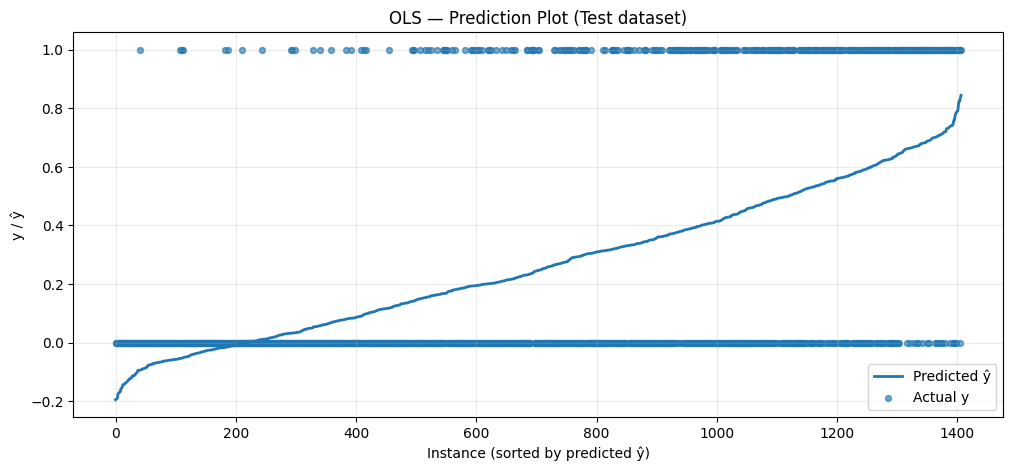

In [ ]:
# ==== 1) Fit statsmodels OLS (with intercept) ====
X_sm = sm.add_constant(X_train, has_constant="add")
X_tm = sm.add_constant(X_test, has_constant="add")
res_ols = sm.OLS(y_train, X_sm).fit()
print(res_ols.summary())

# ==== 2) Predict on test set ====
yhat_test = res_ols.predict(X_tm).to_numpy()
y_test_np = np.asarray(y_test, dtype=float)
resid_test = y_test_np - yhat_test

# ==== 3) Compute test metrics ====
mse  = mean_squared_error(y_test_np, yhat_test)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_np, yhat_test)
r2   = r2_score(y_test_np, yhat_test)

print("\n==== Test set metrics ====")
print(f"R²   : {r2:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")

# ====== 4) Result plot (sorted predictions vs actual) ========
order = np.argsort(yhat_test)
plt.figure(figsize=(12,5))
plt.plot(yhat_test[order], lw=2, label="Predicted ŷ")
plt.scatter(np.arange(len(order)), y_test[order], s=18, alpha=0.65, label="Actual y")
plt.xlabel("Instance (sorted by predicted ŷ)")
plt.ylabel("y / ŷ")
plt.title("OLS — Prediction Plot (Test dataset)")
plt.grid(alpha=0.25)
plt.legend()
plt.show()


Linearity is violated by definition as the dependent variable is not linear. This model can explain about 25% of the overall variance, so it have room for improvement. model predict negative churn in some cases which is not expected to happen in reality.

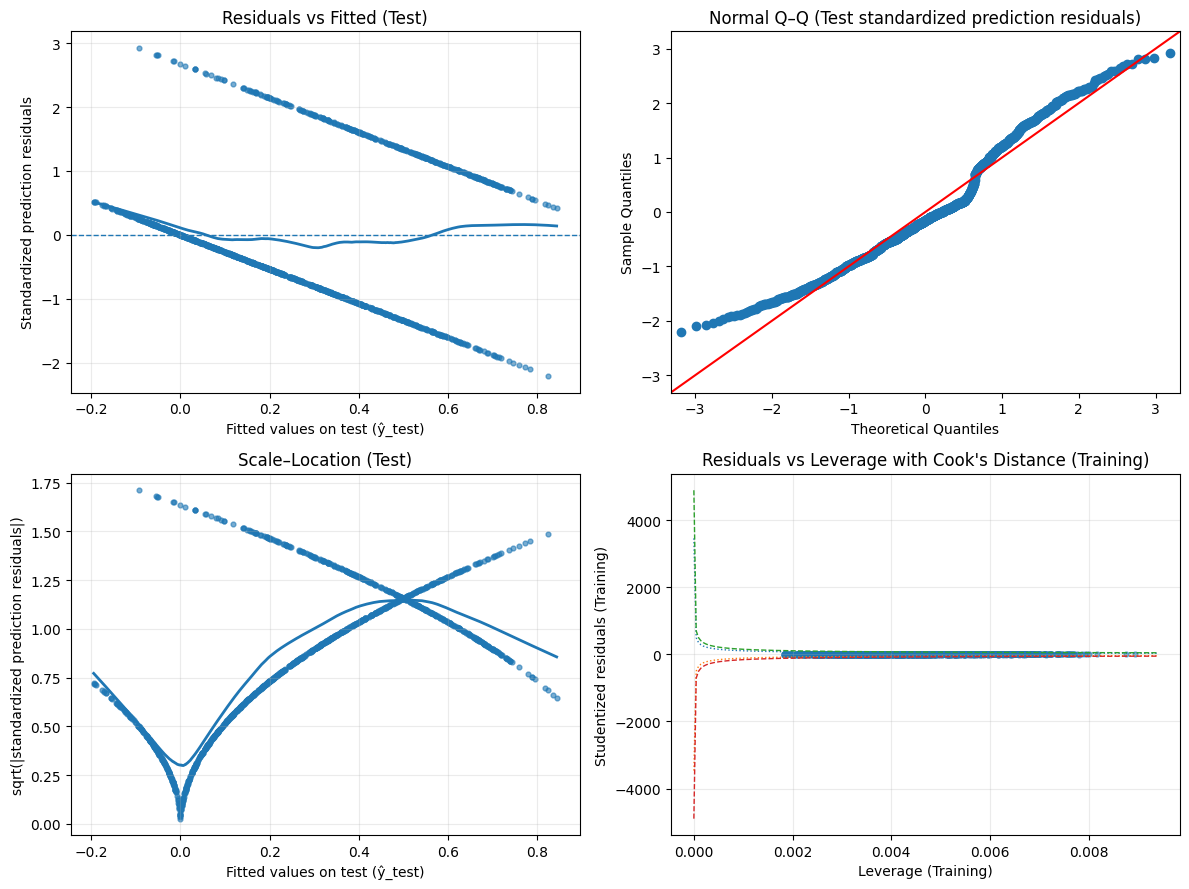

In [ ]:


# --- Using fitted model and splits ---
# Training-based quantities for standardization and Cook's distance
sigma2 = res_ols.mse_resid
XtX_inv = np.linalg.inv(X_sm.T @ X_sm)

yhat_tr   = res_ols.fittedvalues.to_numpy()
infl      = res_ols.get_influence()
resid_std = infl.resid_studentized_internal
resid_stu = infl.resid_studentized_external
lev_tr    = infl.hat_matrix_diag
cooks_tr  = infl.cooks_distance[0]
p         = X_sm.shape[1]


# Test leverage (hat values) relative to training design
# h_i = x_i^T (X^T X)^{-1} x_i
h_test = np.einsum('ij,jk,ik->i', X_tm, XtX_inv, X_tm)

# Standardized prediction residuals: resid / (sigma * sqrt(1 + h))
resid_std_pred = resid_test / np.sqrt(sigma2 * (1.0 + h_test))

# ============= PLOTS =============
fig, axs = plt.subplots(2, 2, figsize=(12, 9))

# (1) Residuals vs Fitted — TEST
axs[0,0].scatter(yhat_test, resid_std_pred, s=12, alpha=0.6)
smth = lowess(resid_std_pred, yhat_test, frac=0.25, it=0, return_sorted=True)
axs[0,0].plot(smth[:,0], smth[:,1], lw=2)
axs[0,0].axhline(0, lw=1, ls="--")
axs[0,0].set_xlabel("Fitted values on test (ŷ_test)")
axs[0,0].set_ylabel("Standardized prediction residuals")
axs[0,0].set_title("Residuals vs Fitted (Test)")
axs[0,0].grid(alpha=0.25)

# (2) Normal Q–Q — TEST standardized prediction residuals
sm.ProbPlot(resid_std_pred).qqplot(line="45", ax=axs[0,1])
axs[0,1].set_title("Normal Q–Q (Test standardized prediction residuals)")

# (3) Scale–Location — TEST
sqrt_abs = np.sqrt(np.abs(resid_std_pred))
axs[1,0].scatter(yhat_test, sqrt_abs, s=12, alpha=0.6)
smth2 = lowess(sqrt_abs, yhat_test, frac=0.25, it=0, return_sorted=True)
axs[1,0].plot(smth2[:,0], smth2[:,1], lw=2)
axs[1,0].set_xlabel("Fitted values on test (ŷ_test)")
axs[1,0].set_ylabel("sqrt(|standardized prediction residuals|)")
axs[1,0].set_title("Scale–Location (Test)")
axs[1,0].grid(alpha=0.25)

# (4) Residuals vs Leverage with Cook’s contours — TRAINING (original)
axs[1,1].scatter(lev_tr, resid_stu, s=12, alpha=0.6)
axs[1,1].set_xlabel("Leverage (Training)")
axs[1,1].set_ylabel("Studentized residuals (Training)")
axs[1,1].set_title("Residuals vs Leverage with Cook's Distance (Training)")

# Cook’s contours
h = np.linspace(1e-6, min(lev_tr.max()*1.05, 0.999), 200)
for D, ls in [(0.5, ":"), (1.0, "--")]:
    bound = np.sqrt(D * p * (1 - h) / h)
    axs[1,1].plot(h,  bound, ls=ls, lw=1)
    axs[1,1].plot(h, -bound, ls=ls, lw=1)
axs[1,1].grid(alpha=0.25)

plt.tight_layout()
plt.show()




Many orther assumptions for linear regression are violated.
1. From the residual vs fitted there is not any homocedasticity of the errors as well as no linearity is confirmed.This is because of the duality of the residuals.
2. From the Q-Q format of errors I can tell that errors are non-normal as they deviate on the tails.
3. From the Scale-Location there is not a flat band or a constant cloud within the center, suggesting heteroskedasticity.
4. Nothing extra to say based on Cook's distance of residuals. Outliers do not seems to be a concern.
5. From the correlation plot in the EDA I could assume that some multicollinearality might be present on the data.
Many assumptions for linear regression are broken, suggesting its likely not the best model. Starting from the fact that the outcome is binary, logistic regression is likely a better baseline model for performance comparison.

### Checking interpretability:

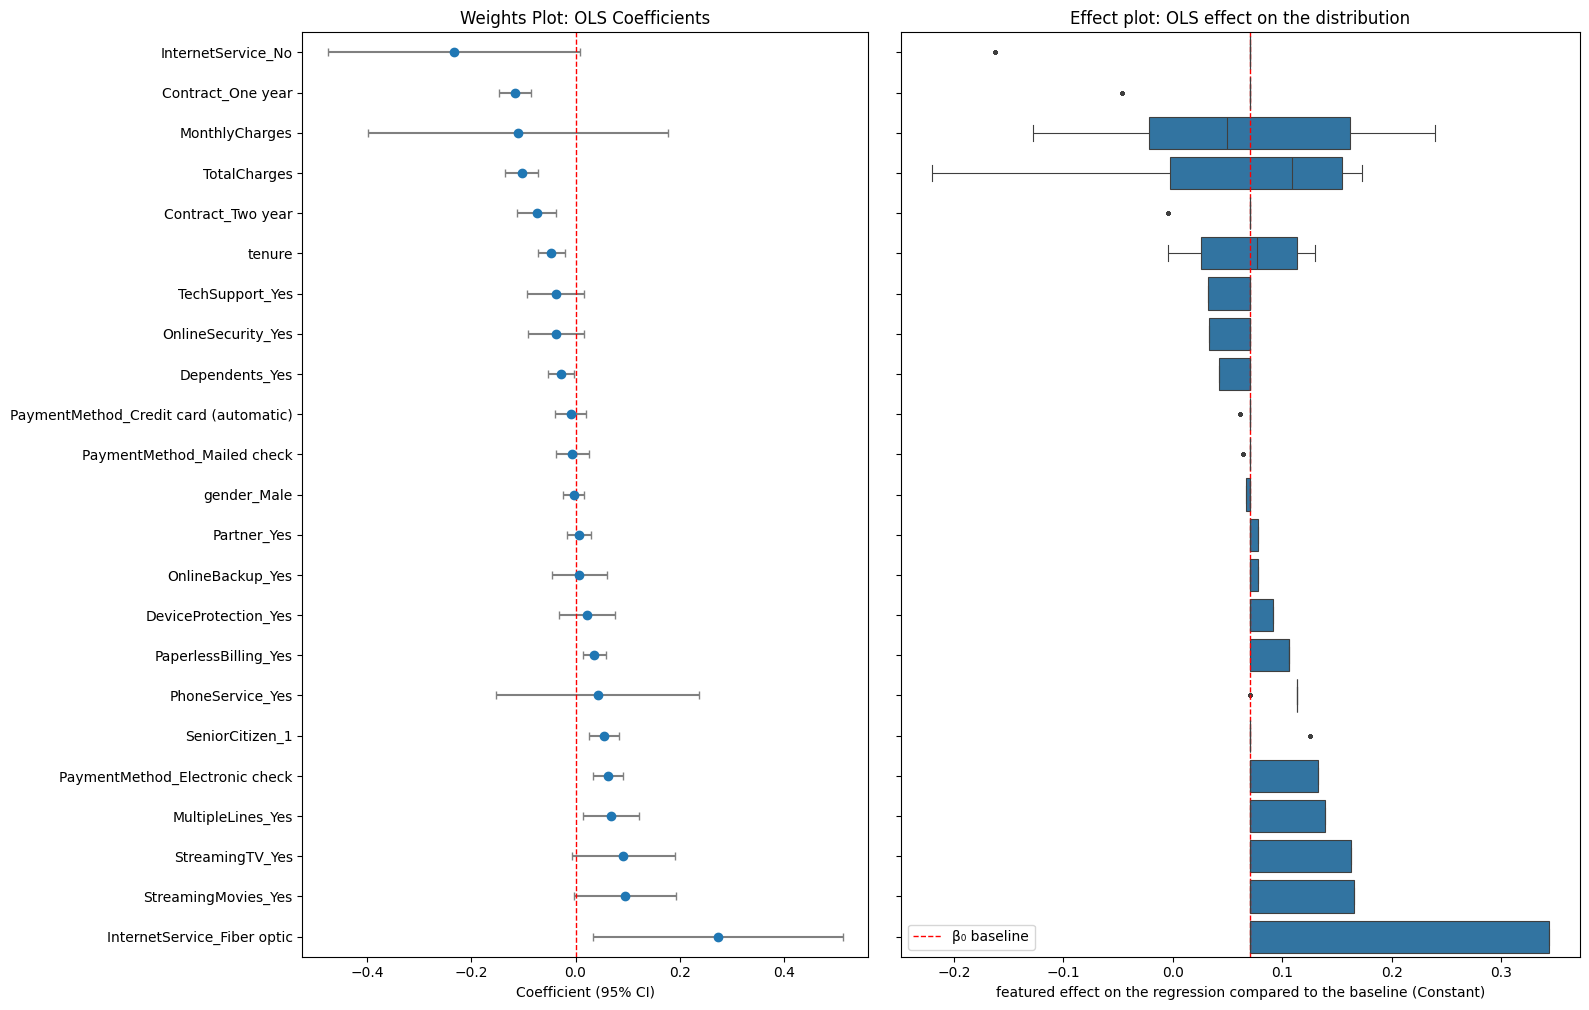

In [ ]:
# 1) Order features by coefficient (same as your weights plot)
params = np.asarray(res_ols.params)          # includes intercept
conf   = np.asarray(res_ols.conf_int())
names  = np.array(["const"] + list(X.columns))

coef  = params[1:]
ci_lo = conf[1:, 0]
ci_hi = conf[1:, 1]
fn    = names[1:]

order = np.argsort(coef)                     # ascending
coef_o, lo_o, hi_o = coef[order], ci_lo[order], ci_hi[order]
names_o = fn[order]                          # y-order for both panels
ypos = np.arange(len(coef_o))

# 2) Build one-term values aligned to the same y-order (β0 + βf * x_f)
params_s = pd.Series(params, index=["const"] + list(X.columns))
b0 = float(params_s["const"])

rows = []
for f in names_o:                            # keep identical ordering
    bf = float(params_s[f])
    xi = X_test[f].astype(float).to_numpy()
    y_one = b0 + bf * xi
    rows.append(pd.DataFrame({"feature": f, "y_one": y_one}))
plot_df = pd.concat(rows, ignore_index=True)
plot_df["feature"] = pd.Categorical(plot_df["feature"],
                                    categories=list(names_o),
                                    ordered=True)

# 3) One figure, two panels (shared y)
fig, (axL, axR) = plt.subplots(
    1, 2,
    figsize=(16, max(4, 0.4*len(names_o)+1)),
    sharey=True,
    gridspec_kw={"width_ratios":[1.0, 1.2]}
)

# Left: OLS coefficient dot plot with 95% CI
axL.errorbar(coef_o, ypos,
             xerr=[coef_o - lo_o, hi_o - coef_o],
             fmt="o", ecolor="gray", capsize=3)
axL.axvline(0, ls="--", color="red", lw=1)
axL.set_yticks(ypos)
axL.set_yticklabels(names_o)
axL.set_xlabel("Coefficient (95% CI)")
axL.set_title("Weights Plot: OLS Coefficients")

# Right: One-term value forest boxes (β0 + βf · x_f)
sns.boxplot(
    data=plot_df, y="feature", x="y_one",
    orient="h", whis=1.5, linewidth=0.8, fliersize=1.5, ax=axR
)
axR.axvline(b0, ls="--", lw=1, color="red", label="β₀ baseline")
axR.set_xlabel("featured effect on the regression compared to the baseline (Constant)")
axR.set_ylabel("")   # shared y from left
axR.legend(loc="lower left")
axR.set_title("Effect plot: OLS effect on the distribution")

plt.tight_layout(w_pad=2.0)
plt.show()



Interpretability of the linear model is fairly straightforward. Customers with fiber optic internet service show the strongest positive association with churn—about a 30 percentage-point higher probability of leaving compared to the baseline category. In contrast, longer contract terms (one- or two-year contracts) substantially reduce churn risk, lowering the predicted probability by 10 points or more relative to month-to-month contracts. These patterns make intuitive sense.

Some results, however, highlight the limitations of the linear probability model. For example, TotalCharges appears negatively associated with churn, which at first glance seems counterintuitive. In reality, this effect is likely capturing tenure: customers with higher accumulated charges tend to have been around longer and are less likely to churn. Since MonthlyCharges and Tenure are already included, this overlap introduces multicollinearity that can distort coefficient signs.

Overall, the coefficient and effect plots give a clear picture of how features influence churn under the linear specification, but the inconsistencies suggest that a logistic regression or more flexible model would provide better calibrated probabilities and cleaner interpretations.

## 3. Logistic Regression
I fit penalized logistic regression (liblinear or saga) and interpret coefficients as odds-ratios. I also check classification metrics and calibration.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5625
Model:                            GLM   Df Residuals:                     5601
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2307.8
Date:                Fri, 12 Sep 2025   Deviance:                       4615.6
Time:                        21:24:40   Pearson chi2:                 6.54e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2864
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

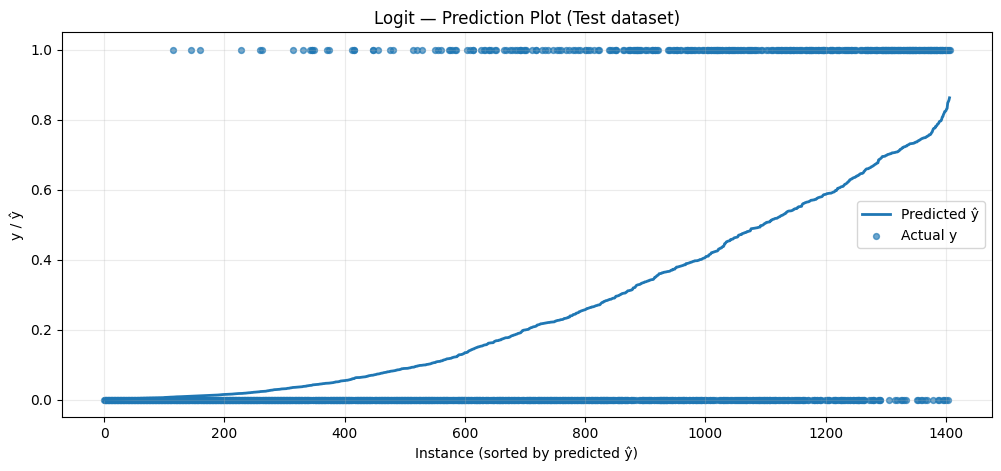

In [ ]:
# ==== 1) Fit statsmodels Logit (with intercept) ====
X_sm = sm.add_constant(X_train, has_constant="add")
X_tm = sm.add_constant(X_test, has_constant="add")
res = sm.GLM(y_train, X_sm, family=sm.families.Binomial()).fit(disp=False)
print(res.summary())

# ==== 2) Predict on test set ====
yhat_test = res.predict(X_tm).to_numpy()
y_test_np = np.asarray(y_test, dtype=float)
resid_test = y_test_np - yhat_test

# ==== 3) Compute test metrics ====
mse  = mean_squared_error(y_test_np, yhat_test)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_np, yhat_test)
r2   = r2_score(y_test_np, yhat_test)

auc   = roc_auc_score(y_test_np, yhat_test)
ll    = log_loss(y_test_np, yhat_test)
brier = brier_score_loss(y_test_np, yhat_test)


print("\n==== Test set metrics ====")
print(f"R²   : {r2:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"AUC         : {auc:.4f}")
print(f"Log loss    : {ll:.4f}")
print(f"Brier score : {brier:.4f}")

# ====== 4) Result plot (sorted predictions vs actual) ========
order = np.argsort(yhat_test)
plt.figure(figsize=(12,5))
plt.plot(yhat_test[order], lw=2, label="Predicted ŷ")
plt.scatter(np.arange(len(order)), y_test[order], s=18, alpha=0.65, label="Actual y")
plt.xlabel("Instance (sorted by predicted ŷ)")
plt.ylabel("y / ŷ")
plt.title("Logit — Prediction Plot (Test dataset)")
plt.grid(alpha=0.25)
plt.legend()
plt.show()


This model is way better at interpretating the possible levels of the variable for instance there is no any sign of negative churn. However the pseudo R-squared still close to 0.3 suggesting a performance of the model that is accuarate a bit less than 1/3 of the time.

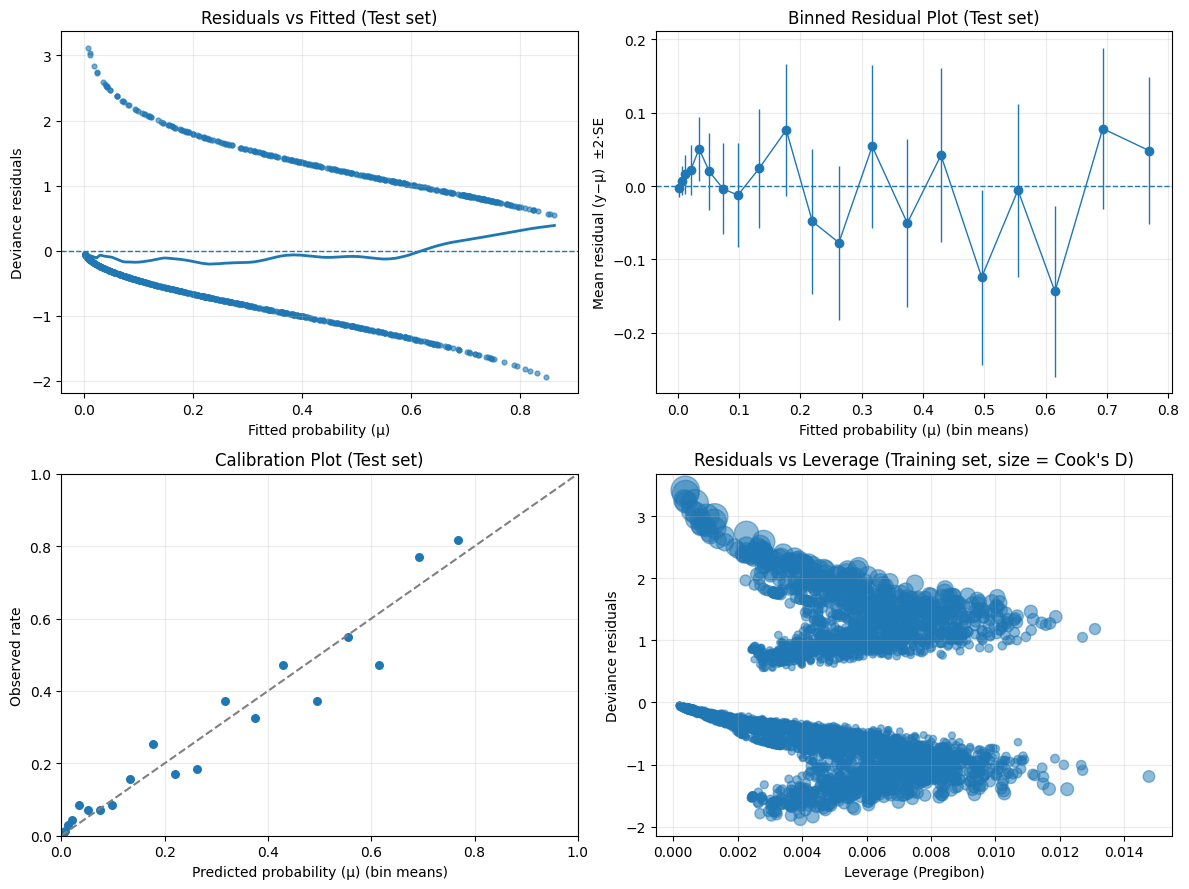

In [ ]:
# ====== 4) TEST diagnostics for panels (1)–(3) ======
mu_test = yhat_test

# Deviance residuals on TEST (binary closed form)
eps = 1e-12
mu_clip = np.clip(mu_test, eps, 1 - eps)
sign = np.sign(y_test_np - mu_clip)
dev_contrib = np.where(y_test_np == 1,
                       -2*np.log(mu_clip),
                       -2*np.log(1 - mu_clip))
resd_test = sign * np.sqrt(dev_contrib)

# Binning by predicted prob (TEST)
bins = pd.qcut(mu_test, q=20, duplicates="drop")
df_b = pd.DataFrame({"mu": mu_test, "y": y_test_np, "bin": bins})
grp = df_b.groupby("bin", observed=True)
mu_bar = grp["mu"].mean().to_numpy()
obs = grp["y"].mean().to_numpy()
n_bin = grp.size().to_numpy()
se = np.sqrt(mu_bar*(1 - mu_bar) / np.maximum(n_bin, 1))

# ====== 5) TRAINING influence for panel (4) ======
infl = res.get_influence(observed=True)           # training-based
lev_tr  = infl.hat_matrix_diag
cooks_tr= infl.cooks_distance[0]
resd_tr = res.resid_deviance.to_numpy()           # training deviance residuals

# ====== 6) Plots ======
fig, axs = plt.subplots(2, 2, figsize=(12, 9))

# (1) Deviance residuals vs fitted — TEST
axs[0,0].scatter(mu_test, resd_test, s=12, alpha=0.6)
smth = lowess(resd_test, mu_test, frac=0.25, it=0, return_sorted=True)
axs[0,0].plot(smth[:,0], smth[:,1], lw=2)
axs[0,0].axhline(0, ls="--", lw=1)
axs[0,0].set_xlabel("Fitted probability (μ)")
axs[0,0].set_ylabel("Deviance residuals")
axs[0,0].set_title("Residuals vs Fitted (Test set)")
axs[0,0].grid(alpha=0.25)

# (2) Binned residuals vs fitted — TEST
axs[0,1].errorbar(mu_bar, (obs - mu_bar), yerr=2*se, fmt="o-", lw=1)
axs[0,1].axhline(0, ls="--", lw=1)
axs[0,1].set_xlabel("Fitted probability (μ) (bin means)")
axs[0,1].set_ylabel("Mean residual (y−μ)  ±2·SE")
axs[0,1].set_title("Binned Residual Plot (Test set)")
axs[0,1].grid(alpha=0.25)

# (3) Calibration (reliability) — TEST
axs[1,0].plot([0,1],[0,1], ls="--", color="gray")
axs[1,0].scatter(mu_bar, obs, s=30)
axs[1,0].set_xlim(0,1); axs[1,0].set_ylim(0,1)
axs[1,0].set_xlabel("Predicted probability (μ) (bin means)")
axs[1,0].set_ylabel("Observed rate")
axs[1,0].set_title("Calibration Plot (Test set)")
axs[1,0].grid(alpha=0.25)

# (4) Deviance residuals vs leverage — TRAINING (size = Cook's D)
sizes = 20 + 400 * (cooks_tr / (cooks_tr.max() if cooks_tr.max() > 0 else 1))
axs[1,1].scatter(lev_tr, resd_tr, s=sizes, alpha=0.5)
axs[1,1].set_xlabel("Leverage (Pregibon)")
axs[1,1].set_ylabel("Deviance residuals")
axs[1,1].set_title("Residuals vs Leverage (Training set, size = Cook's D)")
axs[1,1].grid(alpha=0.25)

plt.tight_layout()
plt.show()

The upper two graph suggest that there are some features no captured by the model specially when the fitted probability increases over 0.6 and deviates from the no residuals.

This could be non-linearalities or interaction between features. Where a GAM model could be more likely to find a better specification.

Just like the linear model, multicollinearity cannot be disregarded as the variables are the same than the one used on the linear model.

### Checking interpretability:

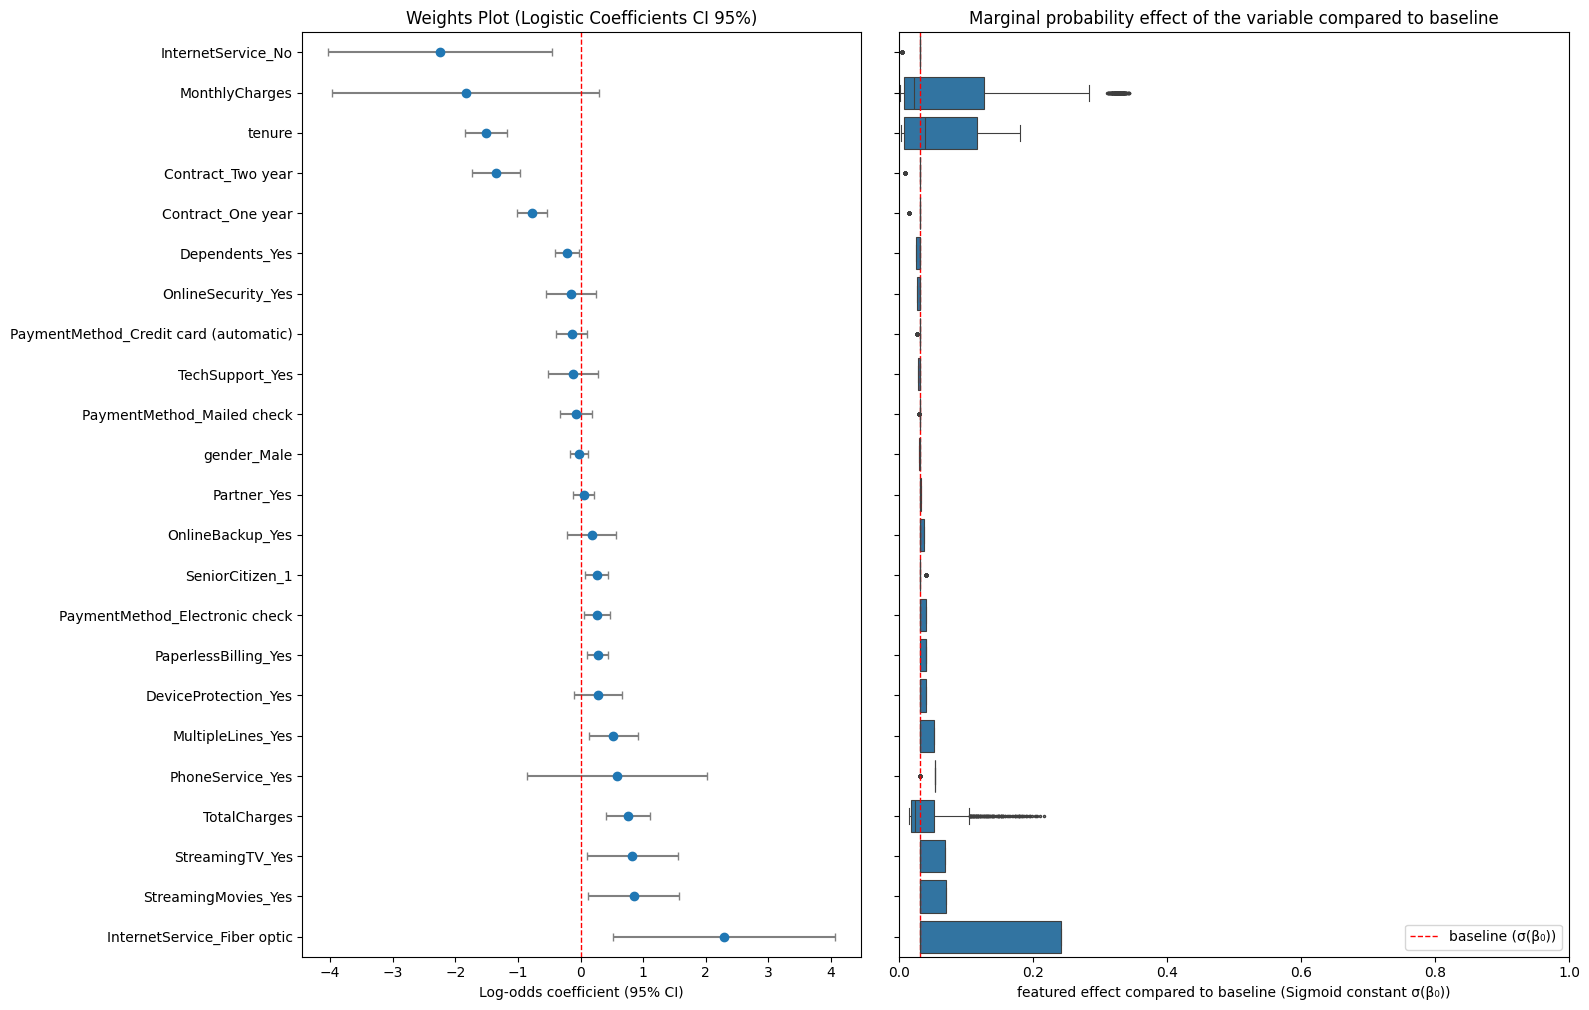

In [ ]:
# ===== 1) Coefs & ordering (exactly your logic) =====
params = np.asarray(res.params)        # includes intercept
conf   = np.asarray(res.conf_int())    # (p+1, 2)
names  = np.array(["const"] + list(X.columns))

coef  = params[1:]
ci_lo = conf[1:, 0]
ci_hi = conf[1:, 1]
fn    = names[1:]

order = np.argsort(coef)               # ascending
coef_o, lo_o, hi_o = coef[order], ci_lo[order], ci_hi[order]
names_o = fn[order]                    # <-- y-order we'll reuse on the right
ypos = np.arange(len(coef_o))

# ===== 2) Build one-term probability data aligned to the same y-order =====
params_s = pd.Series(np.asarray(res.params), index=["const"] + list(X.columns))
b0 = float(params_s["const"])

rows = []
for f in names_o:                      # keep the same ordering
    bf = float(params_s[f])
    xi = X_test[f].astype(float).to_numpy()
    p  = expit(b0 + bf * xi)          # one-term probabilities
    rows.append(pd.DataFrame({"feature": f, "prob": p}))
plot_df = pd.concat(rows, ignore_index=True)
plot_df["feature"] = pd.Categorical(plot_df["feature"],
                                    categories=list(names_o),
                                    ordered=True)

# ===== 3) One figure, two panels (shared y) =====
fig, (axL, axR) = plt.subplots(
    1, 2,
    figsize=(16, max(4, 0.4*len(names_o)+1)),
    sharey=True,
    gridspec_kw={"width_ratios":[1.0, 1.2]}
)

# Left: coefficient dot plot with 95% CI (log-odds)
axL.errorbar(coef_o, ypos,
             xerr=[coef_o - lo_o, hi_o - coef_o],
             fmt="o", ecolor="gray", capsize=3)
axL.axvline(0, ls="--", color="red", lw=1)
axL.set_yticks(ypos)
axL.set_yticklabels(names_o)
axL.set_xlabel("Log-odds coefficient (95% CI)")
axL.set_title("Weights Plot (Logistic Coefficients CI 95%)")

# Right: one-term probability forest boxes + dumbbells
sns.boxplot(
    data=plot_df, y="feature", x="prob",
    orient="h", whis=1.5, linewidth=0.8, fliersize=1.5, ax=axR
)

axR.axvline(expit(b0), ls="--", lw=1, color="red", label="baseline (σ(β₀))")
axR.set_xlabel("featured effect compared to baseline (Sigmoid constant σ(β₀))")
axR.set_ylabel("")   # sharey handles labels from left plot
axR.set_xlim(0, 1)
axR.legend(loc="lower right")
axR.set_title("Marginal probability effect of the variable compared to baseline")

plt.tight_layout(w_pad=2.0)
plt.show()




The logistic model highlights a few clear drivers of churn. Customers with fiber optic internet service stand out as the most at-risk group, with a strong positive log-odds coefficient translating into a ~15–20 percentage-point increase in churn probability compared to the baseline internet category.

In contrast, longer contracts (one- or two-year terms) are strongly protective, substantially lowering churn likelihood relative to month-to-month plans. Continuous features also play a role: higher monthly charges increase churn risk, while greater tenure reduces it, consistent with the intuition that new, high-spending customers are more likely to leave, whereas long-standing customers are more stable.

Other features (e.g., payment method, add-on services) show smaller or uncertain effects, reflecting either weaker associations or overlap with the stronger predictors. Overall, the logistic specification delivers interpretable, directional effects aligned with business expectations, while reducing the distortions seen in the linear probability model.

Importantly, these are conditional effects: logistic coefficients describe changes in log-odds holding other features fixed, so the probability impact depends on the baseline risk. I created some marginal-probability plots for the internet use to illustrate this:

=== Having Internet Baseline probability ===
  InternetService_Fiber optic = 1  |  β=+2.2956  |  β·v=+2.2956
  InternetService_No = 0  |  β=-2.2454  |  β·v=-0.0000
Baseline prob: σ(β0)=0.0309  →  σ(β0|fixed)=0.2408
=== Not having Internet Baseline probability ===
  InternetService_Fiber optic = 0  |  β=+2.2956  |  β·v=+0.0000
  InternetService_No = 1  |  β=-2.2454  |  β·v=-2.2454
Baseline prob: σ(β0)=0.0309  →  σ(β0|fixed)=0.0034


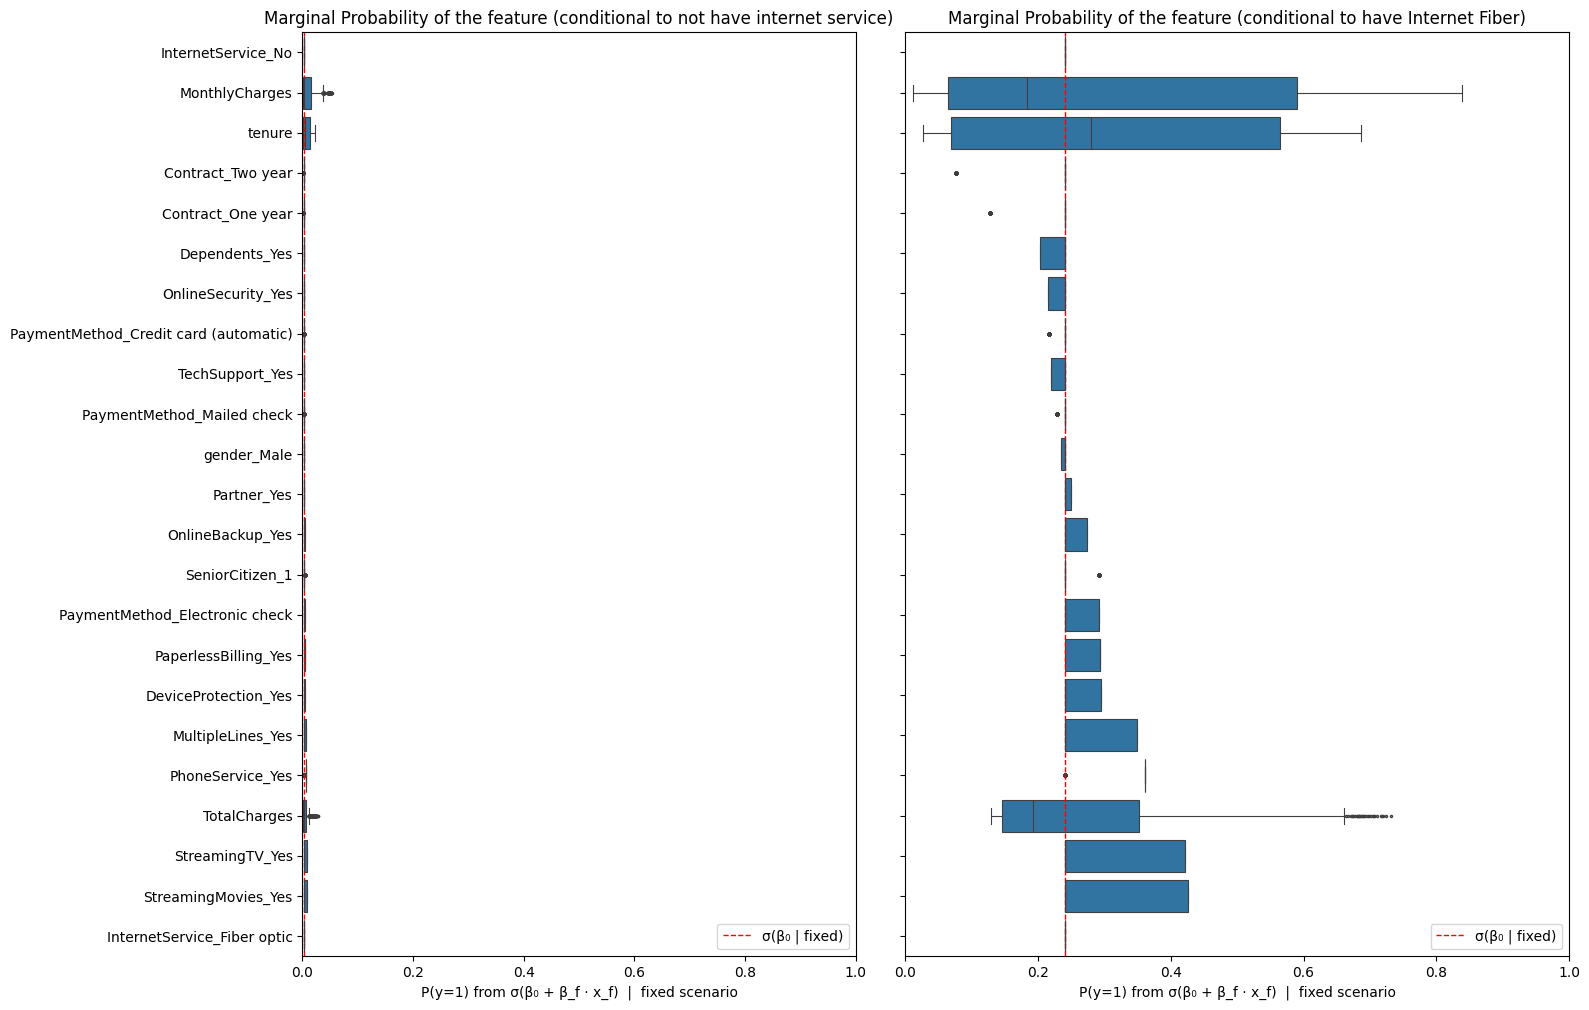

In [ ]:
# ---------- helpers ----------
def _resolve_fixed_value(spec, series: pd.Series):
    if isinstance(spec, (int, float, np.floating)):
        return float(spec)
    s = str(spec).strip().lower()
    if s in {"median", "p50"}: return float(series.quantile(0.50))
    if s == "mean":            return float(series.mean())
    if s.startswith("p") and s[1:].replace(".","",1).isdigit():
        return float(series.quantile(float(s[1:]) / 100.0))
    try: return float(s)
    except: raise ValueError(f"Cannot parse fixed value spec '{spec}'")

def _match_and_summarize_fixed(fixed, X, params_s):
    """Return dict of matched fixed values (converted to numbers),
       list of unmatched keys, and baseline before/after shifts."""
    fixed = fixed or {}
    matched, unmatched = {}, []
    for k, v in fixed.items():
        if k in X.columns:
            matched[k] = _resolve_fixed_value(v, X[k])
        else:
            unmatched.append(k)

    b0 = float(params_s["const"])
    shift = sum(float(params_s[k]) * float(val) for k, val in matched.items() if k in params_s.index)
    b0_fixed = b0 + shift
    return matched, unmatched, b0, b0_fixed

def build_conditional_one_term_plotdf(X, res, feature_order, fixed=None, include_intercept=True):
    params_s = pd.Series(np.asarray(res.params), index=["const"] + list(X.columns))
    fixed_m, _, b0_raw, b0_fixed = _match_and_summarize_fixed(fixed, X, params_s)

    rows = []
    for f in feature_order:
        if f not in X.columns:  # safety
            continue
        # baseline excluding this feature's own contribution
        b0_cond_excl_f = (b0_fixed if include_intercept else 0.0)
        if f in fixed_m:  # subtract self if user also fixed it (we'll add via xi below)
            b0_cond_excl_f -= float(params_s[f]) * float(fixed_m[f])

        bf = float(params_s[f])

        # x_f: observed values unless user fixed f (then a constant vector)
        if f in fixed_m:
            xi = np.full(len(X), float(fixed_m[f]), dtype=float)
        else:
            xi = X[f].astype(float).to_numpy()

        p = expit(b0_cond_excl_f + bf * xi)
        rows.append(pd.DataFrame({"feature": f, "prob": p}))

    plot_df = pd.concat(rows, ignore_index=True)
    plot_df["feature"] = pd.Categorical(plot_df["feature"],
                                        categories=list(feature_order), ordered=True)
    return plot_df


# ---------- diagnostics (optional but recommended) ----------
def print_fixed_diagnostics(X, res, fixed):
    params_s = pd.Series(np.asarray(res.params), index=["const"] + list(X.columns))
    fixed_m, unmatched, b0_raw, b0_fixed = _match_and_summarize_fixed(fixed, X, params_s)
    for k, v in fixed_m.items():
        beta = float(params_s[k])
        print(f"  {k} = {v:.4g}  |  β={beta:+.4f}  |  β·v={beta*v:+.4f}")
    if unmatched:
        print("  (ignored keys not in model columns):", unmatched)
    print(f"Baseline prob: σ(β0)={expit(b0_raw):.4f}  →  σ(β0|fixed)={expit(b0_fixed):.4f}")

# ---------- usage in your two-panel plot ----------
# LEFT PANEL already computed:
#   coef_o, lo_o, hi_o, names_o, ypos

# Define the scenario you want:
fixed_internet = {
    "InternetService_Fiber optic": 1,
    "InternetService_No": 0,
    #"tenure": "p50",               # median tenure
}

fixed_no_internet = {
    "InternetService_Fiber optic": 0,
    "InternetService_No": 1,
    #"tenure": "p50",               # median tenure
}

# (Optional) see exactly what was applied & how baseline changed
print('=== Having Internet Baseline probability ===')
print_fixed_diagnostics(X_test, res, fixed_internet)
print('=== Not having Internet Baseline probability ===')
print_fixed_diagnostics(X_test, res, fixed_no_internet)

# Build right-panel data under these fixed assumptions
plot_df = build_conditional_one_term_plotdf(X_test, res, names_o, fixed=fixed_internet, include_intercept=True)
plot_df_no = build_conditional_one_term_plotdf(X_test, res, names_o, fixed=fixed_no_internet, include_intercept=True)

# Make the figure
fig, (axL, axR) = plt.subplots(
    1, 2, figsize=(16, max(4, 0.4*len(names_o)+1)), sharey=True, gridspec_kw={"width_ratios":[1.0, 1.2]}
)

# Left: conditional one-term probability boxes for not having internet
sns.boxplot(data=plot_df_no, y="feature", x="prob", orient="h", whis=1.5,
            linewidth=0.8, fliersize=1.5, ax=axL)


params_s = pd.Series(np.asarray(res.params), index=["const"] + list(X_test.columns))
_, _, b0_raw, b0_fixed = _match_and_summarize_fixed(fixed_no_internet, X_test, params_s)
axL.axvline(expit(b0_fixed), ls="--", lw=1, color="red", label="σ(β₀ | fixed)")
axL.set_xlabel("P(y=1) from σ(β₀ + β_f · x_f)  |  fixed scenario")
axL.set_ylabel("")
axL.set_xlim(0, 1)
axL.legend(loc="lower right")
axL.set_title("Marginal Probability of the feature (conditional to not have internet service)")

# Right: conditional one-term probability boxes for fabric internet
sns.boxplot(data=plot_df, y="feature", x="prob", orient="h", whis=1.5,
            linewidth=0.8, fliersize=1.5, ax=axR)


# Conditional baseline at σ(β0 + Σ β_j v_j) including *all* fixed terms
params_s = pd.Series(np.asarray(res.params), index=["const"] + list(X_test.columns))
_, _, b0_raw, b0_fixed = _match_and_summarize_fixed(fixed_internet, X_test, params_s)
axR.axvline(expit(b0_fixed), ls="--", lw=1, color="red", label="σ(β₀ | fixed)")
axR.set_xlabel("P(y=1) from σ(β₀ + β_f · x_f)  |  fixed scenario")
axR.set_ylabel("")
axR.set_xlim(0, 1)
axR.legend(loc="lower right")
axR.set_title("Marginal Probability of the feature (conditional to have Internet Fiber)")

plt.tight_layout(w_pad=2.0)
plt.show()




When the baseline case is no internet service, most other features barely move the predicted probability (low baseline risk).

In contrast, under fiber service, the same features (especially monthly charges, tenure, and contract length) shift probabilities substantially.

This subgroup dependence suggests practical value in modeling interactions (e.g., internet type × monthly charges/tenure) or reporting average marginal effects by segment to communicate effect sizes where they matter most.

Overall, interpretability is a bit more complicated than a linear regression, but also more detailed of the underlying reality.

## 4. Generalized Additve models (GAMs)

100% (11 of 11) |########################| Elapsed Time: 0:00:07 Time:  0:00:07
/tmp/ipython-input-2190153668.py:24: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     43.8074
Link Function:                        LogitLink Log Likelihood:                                 -2251.7727
Number of Samples:                         5625 AIC:                                             4591.1603
                                                AICc:                                             4591.896
                                                UBRE:                                               2.8224
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3086
Feature Function                  Lam

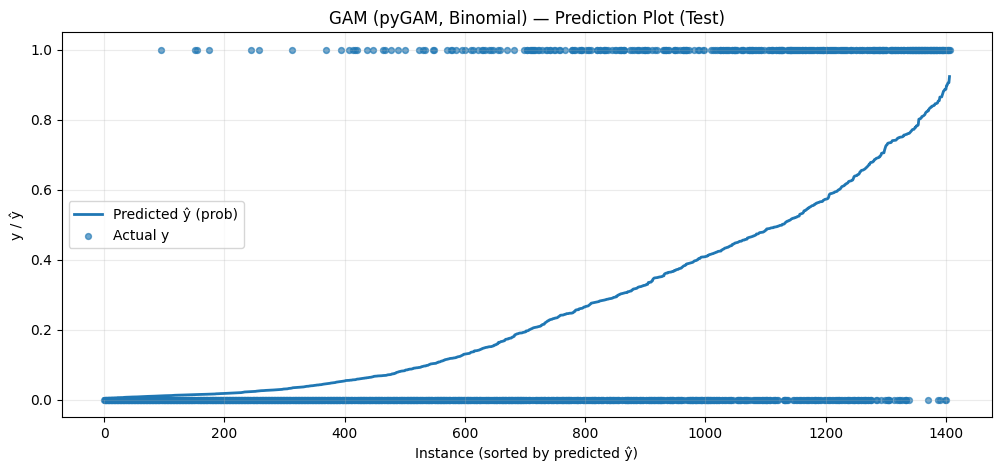

In [ ]:
# ===== 1) Choose smooth vs linear features =====
smooth_cols = ['MonthlyCharges', 'tenure', 'TotalCharges']
smooth_cols = [c for c in smooth_cols if c in X_train.columns]
linear_cols = [c for c in X_train.columns if c not in smooth_cols]

# Keep a consistent column order & map col -> index
cols = smooth_cols + linear_cols
Xtr = X_train[cols].to_numpy(float); Xte = X_test[cols].to_numpy(float)
ytr = y_train.astype(float)
yte = y_test.astype(float)
idx = {c:i for i,c in enumerate(cols)}

# build terms: 3 smooths + remaining linear
term_list = [s(idx['MonthlyCharges']),
             s(idx['tenure']),
             s(idx['TotalCharges'])]
for c in linear_cols: term_list.append(l(idx[c]))
terms = TermList(*term_list)


# ===== 2) Fit Binomial GAM (logit) =====

gam = LogisticGAM(terms=terms, fit_intercept=True).gridsearch(Xtr, ytr)
print(gam.summary())

# ===== 3) Predict on TEST =====
mu_test = gam.predict_proba(Xte)  # probabilities

# ===== 4) Evaluate on TEST =====
auc   = roc_auc_score(yte, mu_test)
ll    = log_loss(yte, mu_test)
brier = brier_score_loss(yte, mu_test)

print("\n==== Test set metrics (pyGAM, Binomial) ====")
print(f"AUC         : {auc:.4f}")
print(f"Log loss    : {ll:.4f}")
print(f"Brier score : {brier:.4f}")

# ===== 5) Prediction plot (sorted) =====
order = np.argsort(mu_test)
plt.figure(figsize=(12,5))
plt.plot(mu_test[order], lw=2, label="Predicted ŷ (prob)")
plt.scatter(np.arange(len(order)), yte[order], s=18, alpha=0.65, label="Actual y")
plt.xlabel("Instance (sorted by predicted ŷ)"); plt.ylabel("y / ŷ")
plt.title("GAM (pyGAM, Binomial) — Prediction Plot (Test)")
plt.grid(alpha=0.25)
plt.legend()
plt.show()


The AUC of this model is slightly better than the logistic regression with a value of 0.8378 vs 0.8317. Depending on the application the increase could be considered negligeble. In this case we really care about having a more accuarate model to avoid churn, so any increase in performance could be considered a win.

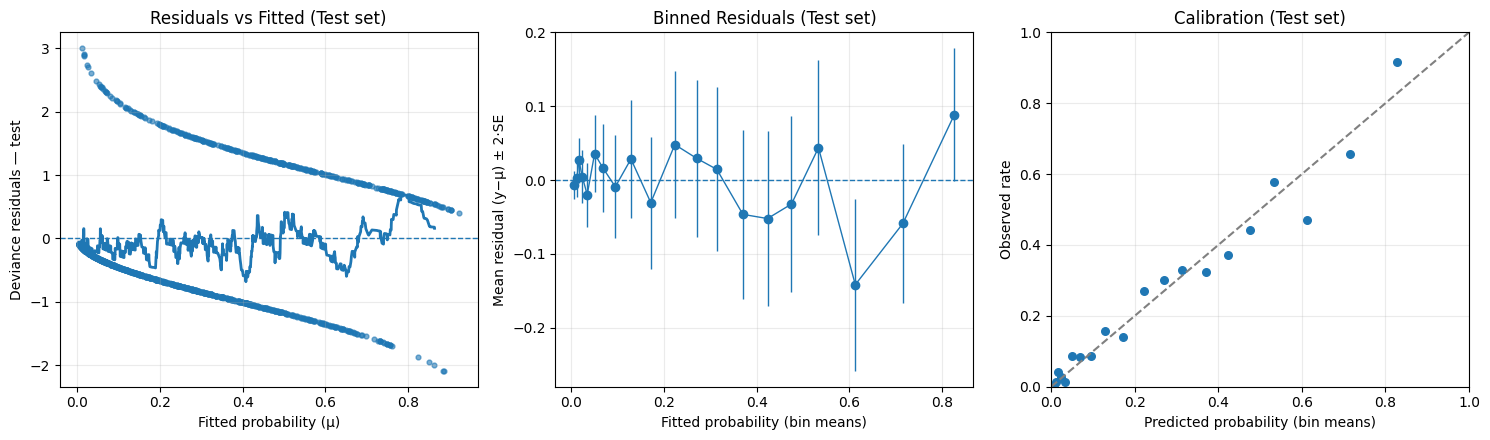

In [ ]:
# ===== 6) Test diagnostics: deviance residuals, binned residuals, calibration =====
eps = 1e-12
mu = np.clip(mu_test, eps, 1-eps)

# Deviance residuals for Bernoulli
sign = np.sign(yte - mu)
dev_contrib = np.where(yte == 1, -2*np.log(mu), -2*np.log(1-mu))
resd = sign * np.sqrt(dev_contrib)

fig, axs = plt.subplots(1, 3, figsize=(15,4.5))

# (a) Residuals vs fitted
axs[0].scatter(mu, resd, s=12, alpha=0.6)
# LOWESS-like smoother (quick moving average for simplicity)
sort = np.argsort(mu)
k = max(5, len(mu)//50)
mv = pd.Series(resd[sort]).rolling(k, center=True).mean()
axs[0].plot(mu[sort], mv, lw=2)
axs[0].axhline(0, ls="--", lw=1)
axs[0].set_xlabel("Fitted probability (μ)")
axs[0].set_ylabel("Deviance residuals — test")
axs[0].set_title("Residuals vs Fitted (Test set)")
axs[0].grid(alpha=0.25)

# (b) Binned residuals
bins = pd.qcut(mu, q=20, duplicates="drop")
dfb = pd.DataFrame({"mu": mu, "y": yte, "bin": bins})
grp = dfb.groupby("bin", observed=True)
mu_bar = grp["mu"].mean().to_numpy()
obs    = grp["y"].mean().to_numpy()
n_bin  = grp.size().to_numpy()
se     = np.sqrt(np.maximum(mu_bar*(1-mu_bar)/np.maximum(n_bin,1), 1e-12))
axs[1].errorbar(mu_bar, (obs - mu_bar), yerr=2*se, fmt="o-", lw=1)
axs[1].axhline(0, ls="--", lw=1)
axs[1].set_xlabel("Fitted probability (bin means)")
axs[1].set_ylabel("Mean residual (y−μ) ± 2·SE")
axs[1].set_title("Binned Residuals (Test set)")
axs[1].grid(alpha=0.25)

# (c) Calibration (reliability)
axs[2].plot([0,1],[0,1], ls="--", color="gray")
axs[2].scatter(mu_bar, obs, s=30)
axs[2].set_xlim(0,1); axs[2].set_ylim(0,1)
axs[2].set_xlabel("Predicted probability (bin means)")
axs[2].set_ylabel("Observed rate")
axs[2].set_title("Calibration (Test set)")
axs[2].grid(alpha=0.25)

plt.tight_layout(); plt.show()

The diagnostic plots show that the GAM model is overall well-calibrated, with predicted churn probabilities closely matching observed churn rates across most of the range. However, the residual analysis highlights that the model struggles in the high-risk segment (above ~60% predicted churn), where it tends to underestimate actual churn likelihood. This means the model reliably distinguishes between low- and medium-risk customers, but may be less accurate in flagging the very highest-risk cases. While performance is strong overall, adding richer interactions or moving to tree-based models could help better capture these extreme cases.

### Checking interpretability:

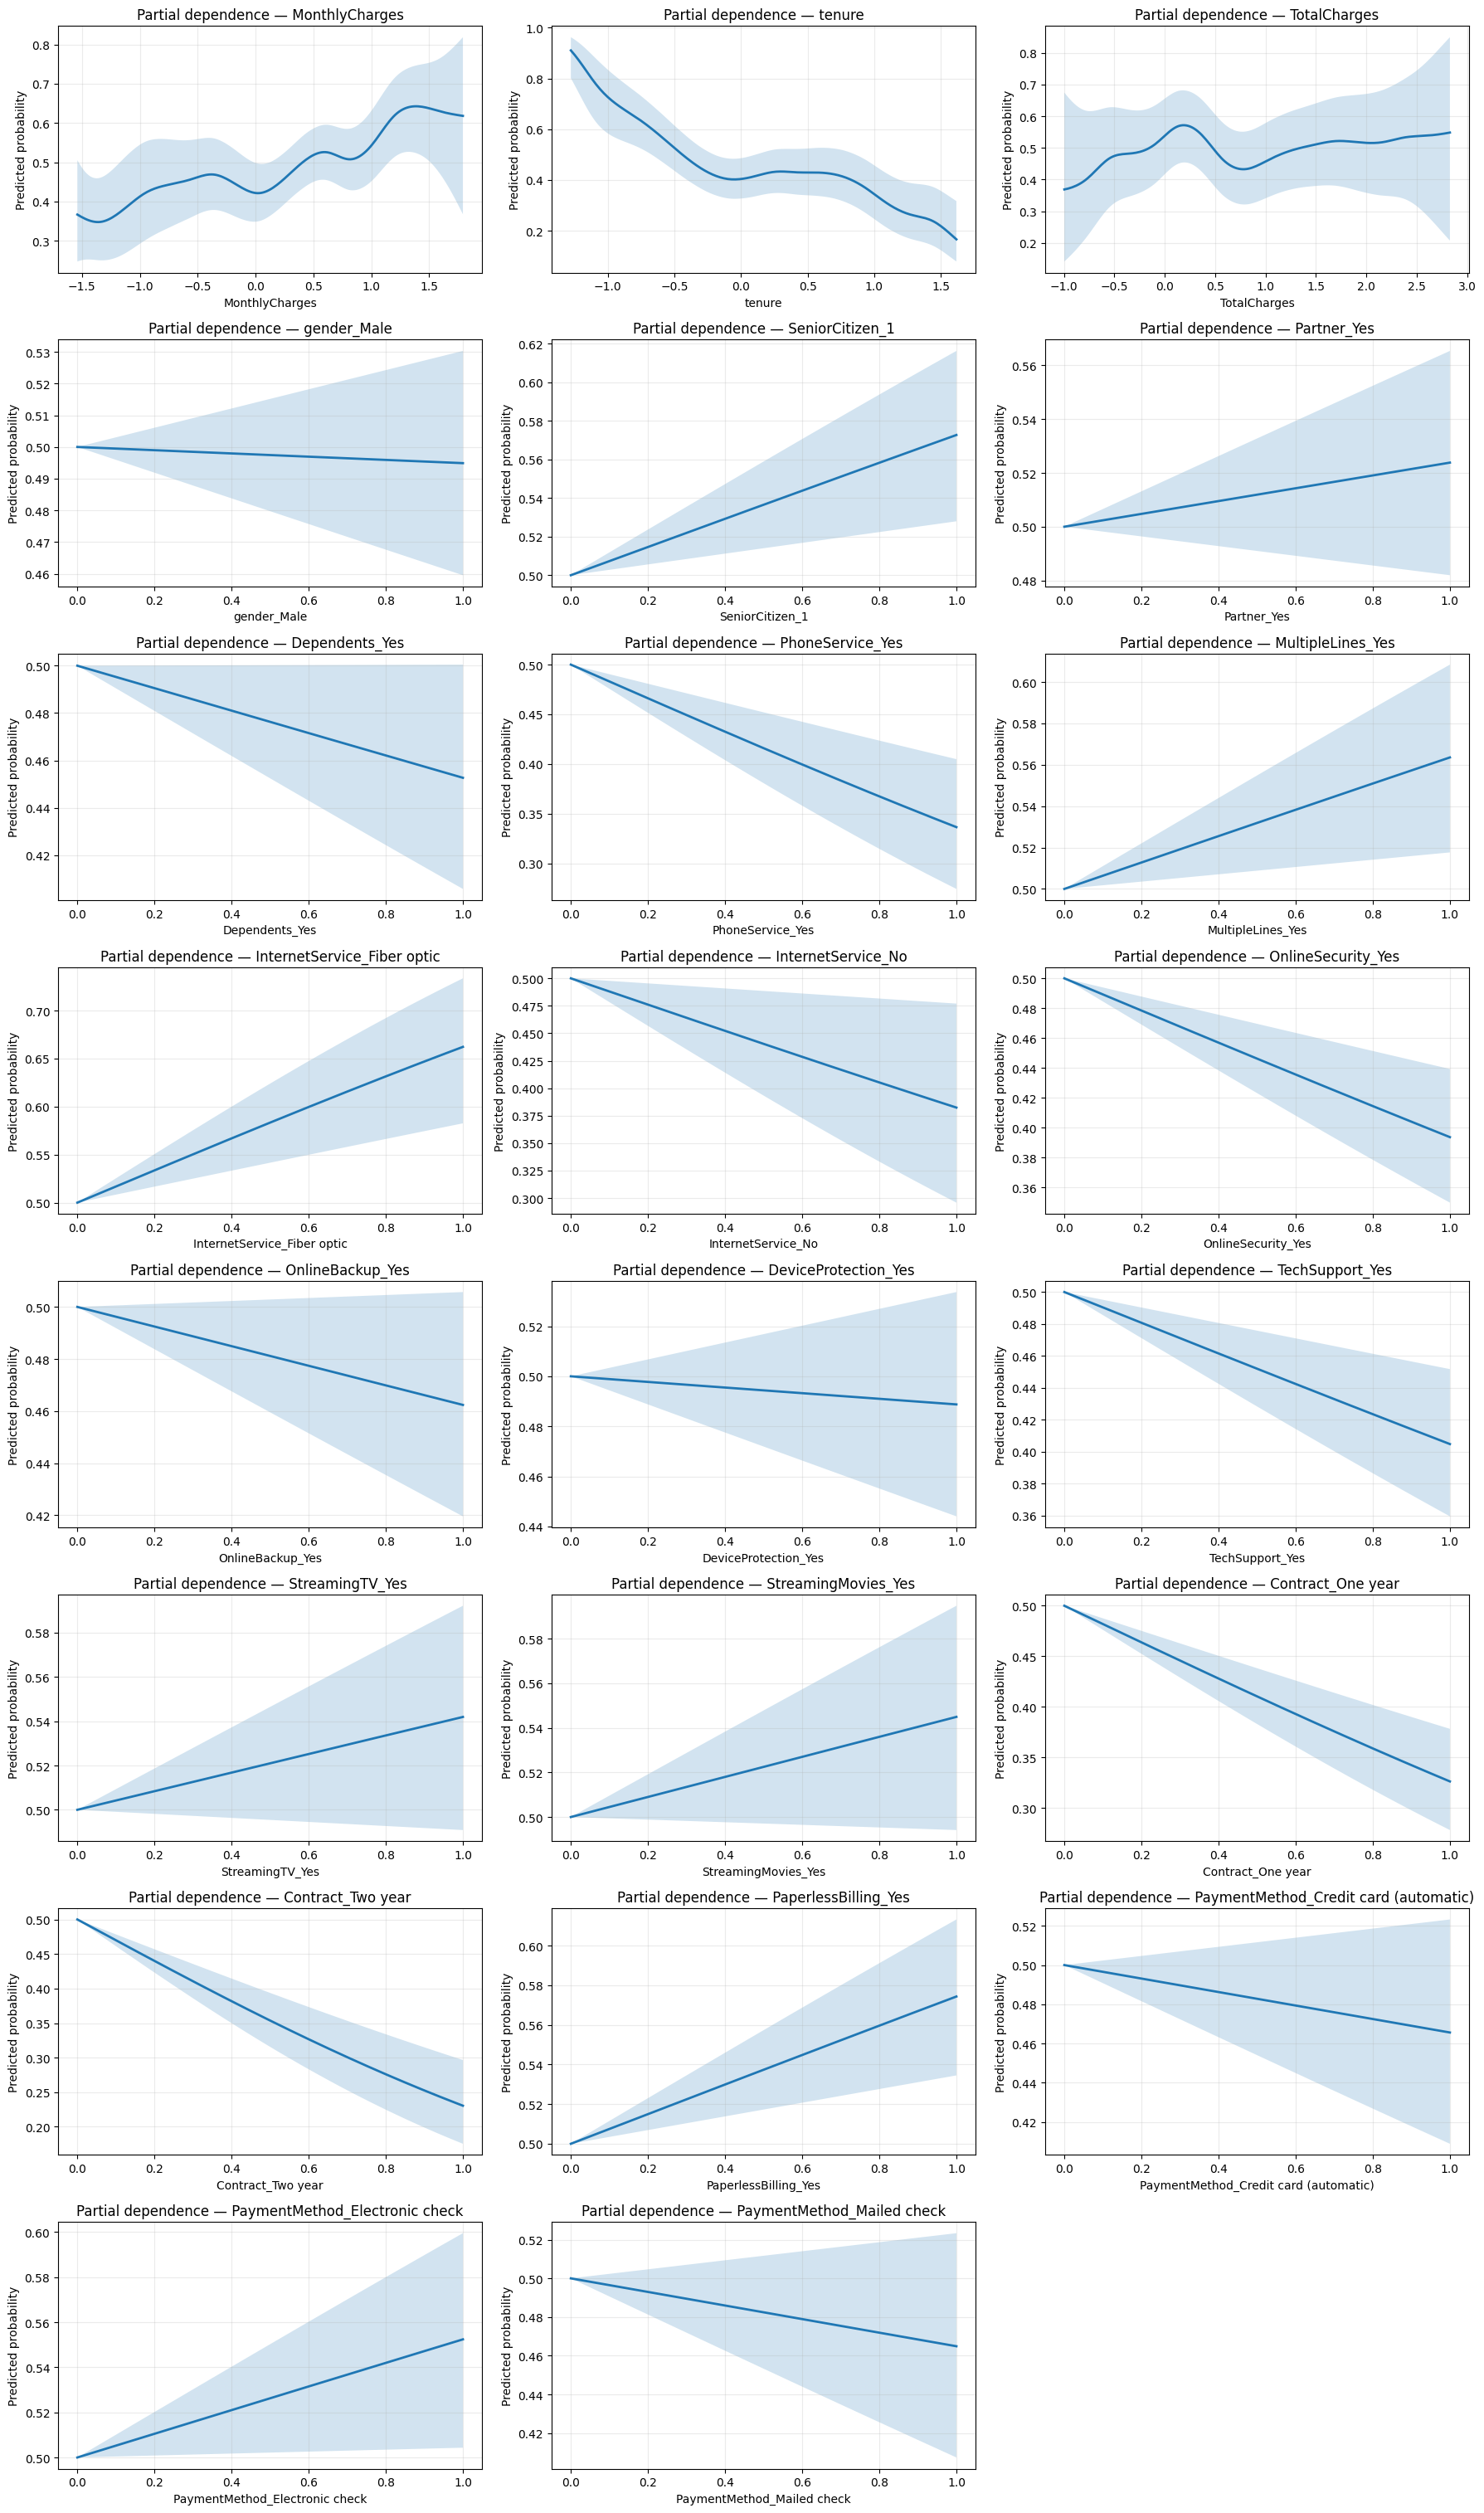

In [ ]:
# --- Partial dependence for all non-interaction terms (probability scale) ---
from scipy.special import expit
import math
import numpy as np
import matplotlib.pyplot as plt

one_d_terms = []
labels = []

for i, term in enumerate(gam.terms):
    # skip intercept
    if getattr(term, "isintercept", False):
        continue

    # get single feature index for s()/l() terms
    feat_idx = getattr(term, "feature", None)
    if feat_idx is None:
        continue

    # sometimes pyGAM exposes a length-1 list; unwrap it
    if isinstance(feat_idx, (list, tuple, np.ndarray)):
        if len(feat_idx) == 1:
            feat_idx = int(feat_idx[0])
        else:
            # if somehow more than one, skip as it's not a pure 1D term
            continue
    else:
        feat_idx = int(feat_idx)

    # map to your column name
    feat_name = cols[feat_idx]
    one_d_terms.append((i, feat_idx))
    labels.append(feat_name)

n = len(one_d_terms)
if n == 0:
    print("No 1D terms found to plot.")
else:
    cols_grid = 3
    rows_grid = math.ceil(n / cols_grid)
    plt.figure(figsize=(6*cols_grid, 3.8*rows_grid))

    for k, ((t_idx, f_idx), lab) in enumerate(zip(one_d_terms, labels), start=1):
        XX = gam.generate_X_grid(term=t_idx, n=200)           # vary this term, others fixed
        pd_link, ci_link = gam.partial_dependence(term=t_idx, X=XX, width=0.95)
        xgrid = XX[:, f_idx]

        # logit -> probability
        pd_prob = expit(pd_link)
        lo = expit(ci_link[:, 0])
        hi = expit(ci_link[:, 1])

        ax = plt.subplot(rows_grid, cols_grid, k)
        ax.plot(xgrid, pd_prob, lw=2)
        ax.fill_between(xgrid, lo, hi, alpha=0.2, linewidth=0)
        ax.set_title(f"Partial dependence — {lab}")
        ax.set_xlabel(lab)
        ax.set_ylabel("Predicted probability")
        ax.grid(alpha=0.25)

    plt.tight_layout()
    plt.show()


The partial dependence plots from the GAM reveal that churn risk is strongly shaped by tenure, contract type, and internet service, while other features play secondary roles.

Customers with shorter tenure and higher monthly charges face higher churn risk, though the relationship is non-linear, with risk declining steadily as tenure increases.

Long-term contracts and add-on services such as tech support or online security consistently reduce churn probability, while fiber optic internet is associated with higher risk. D

Demographic factors like being a senior citizen slightly increase churn, whereas having dependents or a partner lowers it.

Overall, the plots highlight both expected business drivers and nuanced non-linear effects that a standard logistic model would miss.


## 5. Final Recommendations

The best interpretable model would be a GAM for this case.

For churn (binary), a Linear Probability Model (OLS) is the weakest choice: it’s heteroskedastic, can predict outside [0,1], and mis-specifies the mean—useful for a quick sanity check only. As we saw through the document is also very clear on the interpretation of the coefficient.

A logistic regression is the right baseline: it gives valid probabilities, is simple to maintain, and performed well here. But your GAM consistently beat logit on the test set (AUC 0.838 vs 0.832; lower log-loss/Brier) and, more importantly, captured meaningful nonlinearities with clearer calibration in the mid–high risk range. Those shapes are actionable and explain where risk rises, which helps targeting in a real application setting. Let see, how much better is GAM compared to logistic


In [ ]:
import numpy as np

def extra_per_100_at_k(y_true, p_gam, p_logit, k=0.50):
    n = len(y_true)
    m = int(np.ceil(k*n))
    # indices of top-k% by each model
    top_gam = np.argsort(-p_gam)[:m]
    top_log = np.argsort(-p_logit)[:m]
    # churns captured
    gam_tp = y_true[top_gam].sum()
    log_tp = y_true[top_log].sum()
    total_churn = y_true.sum()
    diff = gam_tp - log_tp
    return diff, (diff / total_churn) * 100, gam_tp, log_tp, total_churn

# y_test: 0/1 array; p_gam, p_logit: predicted probabilities on TEST
diff, per100, gam_tp, log_tp, tot = extra_per_100_at_k(y_test.astype(int), p_gam, p_logit, k=0.50)
print(f"Top 50%: GAM={gam_tp}/{tot}, Logit={log_tp}/{tot}, Δ={diff} "
      f"≈ {per100:.1f} extra churners per 100")



Top 50%: GAM=329/374, Logit=313/374, Δ=16 ≈ 4.3 extra churners per 100


In business terms, if the client is paying \$500 dollar a year and the company has 10,000 users. Using the GAM model over the Logistic model will help to avoid almost ($500)x(4)x(100) = \$200,000 just by picking the GAM model.